In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import uproot

In [3]:
N = 20000

file = uproot.open('data/merged_20000_evts.root')
tree = file['ttree']

pid = tree['truthpar_id'].array(library='np', entry_stop=N)
px = tree['truthpar_px'].array(library='np', entry_stop=N)
py = tree['truthpar_py'].array(library='np', entry_stop=N)
pz = tree['truthpar_pz'].array(library='np', entry_stop=N)

pid = np.concatenate(pid,axis=0)
pid = (pid == 22).astype(int)

px = np.concatenate(px,axis=0)
py = np.concatenate(py,axis=0)
pz = np.concatenate(pz,axis=0)

In [10]:
pt = []
eta = []
phi = []

for i in range(N):
    pt.append(np.sqrt(px[i]*px[i]+py[i]*py[i]))
    p = np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i])
    eta.append(0.5 * np.log((p + pz[i]) / (p - pz[i])))
    phi.append(np.arctan2(py[i],px[i]))
    
pt = np.array(pt)
eta = np.array(eta)
phi = np.array(phi)

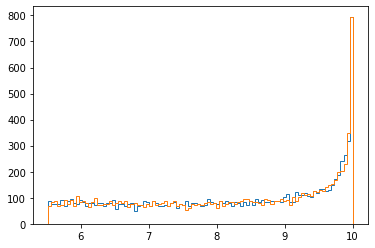

In [17]:
plt.hist(pt[pid == 1],bins=100,histtype="step")
plt.hist(pt[pid == 0],bins=100,histtype="step");

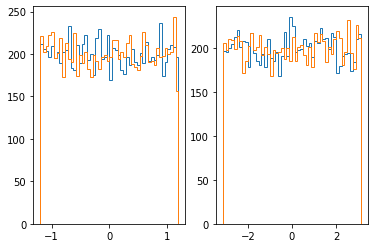

In [18]:
plt.subplot(1,2,1)
plt.hist(eta[pid == 1],bins=50,histtype="step")
plt.hist(eta[pid == 0],bins=50,histtype="step");

plt.subplot(1,2,2)
plt.hist(phi[pid == 1],bins=50,histtype="step")
plt.hist(phi[pid == 0],bins=50,histtype="step");

In [20]:
e_tow = tree['emcalen'].array(library='np', entry_stop=N)
eta_tow = tree['emcalet'].array(library='np', entry_stop=N)
phi_tow = tree['emcalph'].array(library='np', entry_stop=N)

In [37]:
eta_values = set()

for et in eta_tow:
    eta_values = eta_values.union(set(et))
    
eta_values = list(eta_values)
eta_values.sort()

eta_dict = dict()

for i,et in enumerate(eta_values):
    eta_dict[et] = i

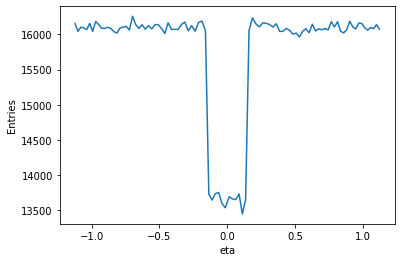

In [102]:
counts = np.zeros((96,))

for et in eta_tow:
    for i,ev in enumerate(eta_values):
        if ev in et:
            counts[i] += 1

plt.plot(eta_values,counts)
plt.xlabel("eta")
plt.ylabel("Entries");

In [42]:
phi_values = set()

for ph in phi_tow:
    phi_values = phi_values.union(set(ph))
    
phi_values = list(phi_values)
phi_values.sort()

phi_dict = dict()

for i,ph in enumerate(phi_values):
    phi_dict[ph] = i

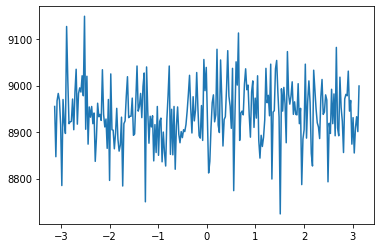

In [43]:
counts = np.zeros((256,))

for ph in phi_tow:
    for i,pv in enumerate(phi_values):
        if pv in ph:
            counts[i] += 1

plt.plot(phi_values,counts);

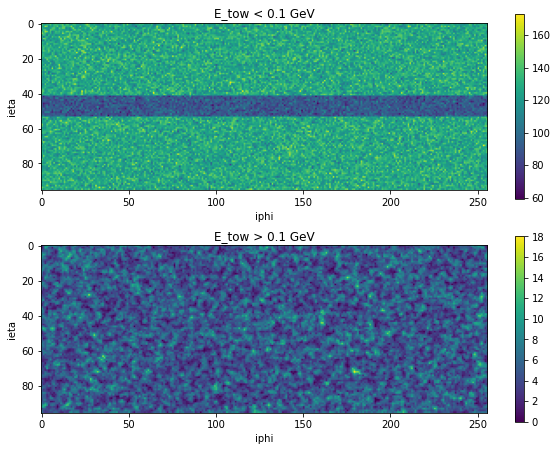

In [101]:
counts = np.zeros((96,256))
counts2 = np.zeros((96,256))

for ph,et,e in zip(phi_tow,eta_tow,e_tow):
    for i,j,k in zip(ph,et,e):
        if k < 0.1:
            counts[eta_dict[j]][phi_dict[i]] += 1
        else:
            counts2[eta_dict[j]][phi_dict[i]] += 1
       
fig, (ax1, ax2) = plt.subplots(figsize=(10, 7.5), ncols=1, nrows=2)
im1 = ax1.imshow(counts)
fig.colorbar(im1,ax=ax1)
ax1.set(title="E_tow < 0.1 GeV",xlabel="iphi",ylabel="ieta")
im2 = ax2.imshow(counts2)
fig.colorbar(im2,ax=ax2)
ax2.set(title="E_tow > 0.1 GeV",xlabel="iphi",ylabel="ieta");

In [8]:
ieta_tow = []
iphi_tow = [] 

for et,ph in zip(eta_tow,phi_tow):
    ieta_event = []
    iphi_event = []
    for e,p in zip(et,ph):
        ieta_event.append(eta_dict[e])
        iphi_event.append(phi_dict[p])
    ieta_tow.append(np.array(ieta_event))
    iphi_tow.append(np.array(iphi_event))
    
ieta_tow = np.array(ieta_tow,dtype=object)
iphi_tow = np.array(iphi_tow,dtype=object)

In [9]:
seed_e = np.zeros(N)
seed_eta = np.zeros(N)
seed_ieta = np.zeros(N,dtype=int)
seed_phi = np.zeros(N)
seed_iphi = np.zeros(N,dtype=int)

nmax_e = np.zeros(N)
nmax_eta = np.zeros(N)
nmax_ieta = np.zeros(N,dtype=int)
nmax_phi = np.zeros(N)
nmax_iphi = np.zeros(N,dtype=int)

eta_zero = []
phi_zero = []

i = 0
for e,et,ph in zip(e_tow,eta_tow,phi_tow):
    e_copy = e.copy()
    e_copy.sort()
    seed_e[i] = e_copy[-1]
    seed_index = list(e).index(seed_e[i])
    seed_eta[i] = et[seed_index]
    seed_ieta[i] = eta_dict[seed_eta[i]]
    seed_phi[i] = ph[seed_index]
    seed_iphi[i] = phi_dict[seed_phi[i]]
    
    nmax_e[i] = e_copy[-2]
    nmax_index = list(e).index(nmax_e[i])
    nmax_eta[i] = et[nmax_index]
    nmax_ieta[i] = eta_dict[nmax_eta[i]]
    nmax_phi[i] = ph[nmax_index]
    nmax_iphi[i] = phi_dict[nmax_phi[i]]
    
    
    if seed_e[i] < 0.1:
        eta_zero.append(eta[i])
        phi_zero.append(phi[i])
    
    i += 1

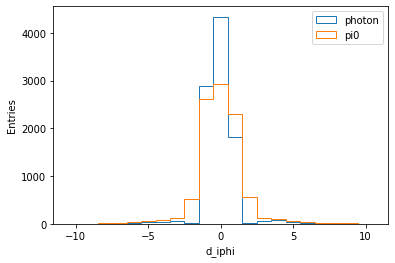

In [10]:
d_iphi_pho = (seed_iphi[pid == 1]-nmax_iphi[pid == 1])
d_iphi_pho[d_iphi_pho >= 128] = 256 - d_iphi_pho[d_iphi_pho >= 128]
d_iphi_pho[d_iphi_pho < -128] = 256 + d_iphi_pho[d_iphi_pho < -128]

d_iphi_pi0 = (seed_iphi[pid == 0]-nmax_iphi[pid == 0])
d_iphi_pi0[d_iphi_pi0 >= 128] = 256 - d_iphi_pi0[d_iphi_pi0 >= 128]
d_iphi_pi0[d_iphi_pi0 < -128] = 256 + d_iphi_pi0[d_iphi_pi0 < -128]

plt.hist(d_iphi_pho,bins=np.arange(-10.5, 10.5+1, 1),histtype="step",label="photon")
plt.hist(d_iphi_pi0,bins=np.arange(-10.5, 10.5+1, 1),histtype="step",label="pi0")
plt.xlabel("d_iphi")
plt.ylabel("Entries")
plt.legend();

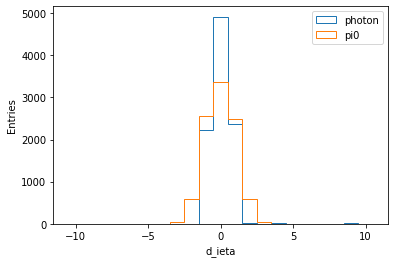

In [11]:
d_ieta_pho = (seed_ieta[pid == 1]-nmax_ieta[pid == 1])
d_ieta_pi0 = (seed_ieta[pid == 0]-nmax_ieta[pid == 0])

plt.hist(d_ieta_pho,bins=np.arange(-10.5, 10.5+1, 1),histtype="step",label="photon")
plt.hist(d_ieta_pi0,bins=np.arange(-10.5, 10.5+1, 1),histtype="step",label="pi0")
plt.xlabel("d_ieta")
plt.ylabel("Entries")
plt.legend();

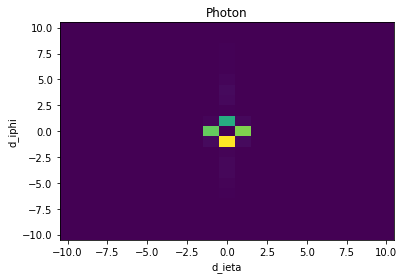

In [12]:
plt.hist2d(d_ieta_pho,d_iphi_pho,bins=np.arange(-10.5, 10.5+1, 1))
plt.xlabel("d_ieta")
plt.ylabel("d_iphi")
plt.title("Photon");

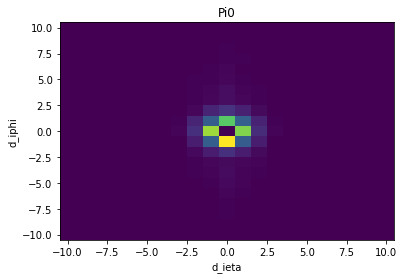

In [13]:
plt.hist2d(d_ieta_pi0,d_iphi_pi0,bins=np.arange(-10.5, 10.5+1, 1))
plt.xlabel("d_ieta")
plt.ylabel("d_iphi")
plt.title("Pi0");

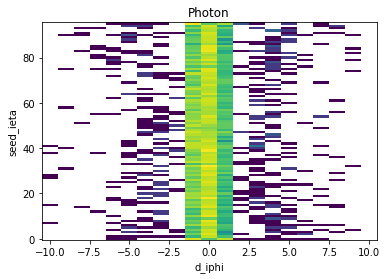

In [29]:
plt.hist2d(d_iphi_pho,seed_ieta[pid == 1],bins=[np.arange(-10.5, 10.5+1, 1),np.arange(-0.5, 95.5+1, 1)],norm=matplotlib.colors.LogNorm())
plt.xlabel("d_iphi")
plt.ylabel("seed_ieta")
plt.title("Photon");

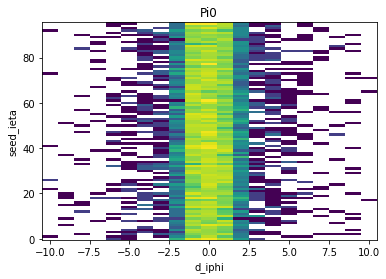

In [30]:
plt.hist2d(d_iphi_pi0,seed_ieta[pid == 1],bins=[np.arange(-10.5, 10.5+1, 1),np.arange(-0.5, 95.5+1, 1)],norm=matplotlib.colors.LogNorm())
plt.xlabel("d_iphi")
plt.ylabel("seed_ieta")
plt.title("Pi0");

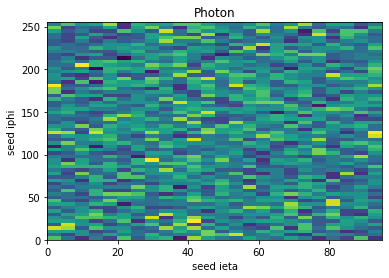

In [59]:
plt.hist2d(seed_ieta[pid == 1],seed_iphi[pid == 1],bins=[96//4,256//4])
plt.xlabel("seed ieta")
plt.ylabel("seed iphi")
plt.title("Photon");

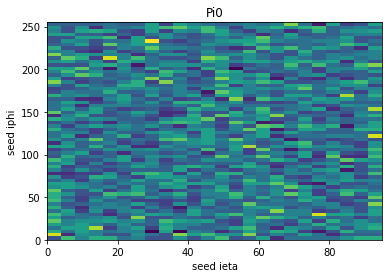

In [60]:
plt.hist2d(seed_ieta[pid == 0],seed_iphi[pid == 0],bins=[96//4,256//4])
plt.xlabel("seed ieta")
plt.ylabel("seed iphi")
plt.title("Pi0");